# ABS Monthly Consumer Price Index Indicator 6484

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Set-up-some-constants-we-will-use-across-all-plots" data-toc-modified-id="Set-up-some-constants-we-will-use-across-all-plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Set-up some constants we will use across all plots</a></span></li><li><span><a href="#Remove-the-old-charts" data-toc-modified-id="Remove-the-old-charts-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Remove the old charts</a></span></li><li><span><a href="#What-are-we-working-with" data-toc-modified-id="What-are-we-working-with-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>What are we working with</a></span></li></ul></li></ul></div>

## Python set-up

In [1]:
# system imports
import sys
import pathlib  
import calendar
import re

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List, Dict

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_plot_constants,
    get_ABS_meta_and_data,
    get_identifier,
    plot_growth2
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '6484'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

## Get data from ABS

In [3]:
# do the data capture and extraction to a DataFrame
abs_dict = get_ABS_meta_and_data(catalogue_id, verbose=True)
if abs_dict is None:
    sys.exit(-1)

Selecting 0 from list: []
Did not find the URL for a ZIP file
URL list of excel files identified
-3--> ['/statistics/economy/price-indexes-and-inflation/monthly-consumer-price-index-indicator/nov-2022/648401.xlsx', '/statistics/economy/price-indexes-and-inflation/monthly-consumer-price-index-indicator/nov-2022/648402.xlsx']
Cache file name: ./ABS_CACHE/_statistics_economy_price-indexes-and-inflation_monthly-consumer-price-index-indicator_nov-2022_648401.zip
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


## Plot

### Set-up some constants we will use across all plots

In [4]:
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)

### Remove the old charts
We do this because the top expenditue item charts are uniquely named

In [5]:
for filename in pathlib.Path(CHART_DIR).glob("*.png"):
    filename.unlink()

### What are we working with

In [6]:
meta

,Data Item Description,Series Type,Series ID,Series Start,Series End,No. Obs.,Unit,Data Type,Freq.,Collection Month,Table,Table Description
1,Index Numbers ; All groups CPI ; Australia ;,Original,A128478317T,2017-09-01,2022-11-01,63.0,Index Numbers,INDEX,Month,1.0,1,"Monthly CPI Indicator: All groups, Groups, select Expenditure classes and Analytical series, Aus..."
2,Index Numbers ; Food and non-alcoholic beverages ; Australia ;,Original,A128480733V,2017-09-01,2022-11-01,63.0,Index Numbers,INDEX,Month,1.0,1,"Monthly CPI Indicator: All groups, Groups, select Expenditure classes and Analytical series, Aus..."
3,Index Numbers ; Bread and cereal products ; Australia ;,Original,A128475629X,2017-09-01,2022-11-01,63.0,Index Numbers,INDEX,Month,1.0,1,"Monthly CPI Indicator: All groups, Groups, select Expenditure classes and Analytical series, Aus..."
4,Index Numbers ; Meat and seafoods ; Australia ;,Original,A128479215W,2017-09-01,2022-11-01,63.0,Index Numbers,INDEX,Month,1.0,1,"Monthly CPI Indicator: All groups, Groups, select Expenditure classes and Analytical series, Aus..."
5,Index Numbers ; Dairy and related products ; Australia ;,Original,A128477405X,2017-09-01,2022-11-01,63.0,Index Numbers,INDEX,Month,1.0,1,"Monthly CPI Indicator: All groups, Groups, select Expenditure classes and Analytical series, Aus..."
6,Index Numbers ; Fruit and vegetables ; Australia ;,Original,A128480215V,2017-09-01,2022-11-01,63.0,Index Numbers,INDEX,Month,1.0,1,"Monthly CPI Indicator: All groups, Groups, select Expenditure classes and Analytical series, Aus..."
7,Index Numbers ; Food products n.e.c. ; Australia ;,Original,A128475329W,2017-09-01,2022-11-01,63.0,Index Numbers,INDEX,Month,1.0,1,"Monthly CPI Indicator: All groups, Groups, select Expenditure classes and Analytical series, Aus..."
8,Index Numbers ; Non-alcoholic beverages ; Australia ;,Original,A128473623X,2017-09-01,2022-11-01,63.0,Index Numbers,INDEX,Month,1.0,1,"Monthly CPI Indicator: All groups, Groups, select Expenditure classes and Analytical series, Aus..."
9,Index Numbers ; Alcohol and tobacco ; Australia ;,Original,A128477399R,2017-09-01,2022-11-01,63.0,Index Numbers,INDEX,Month,1.0,1,"Monthly CPI Indicator: All groups, Groups, select Expenditure classes and Analytical series, Aus..."
10,Index Numbers ; Alcoholic beverages ; Australia ;,Original,A128479281V,2017-09-01,2022-11-01,63.0,Index Numbers,INDEX,Month,1.0,1,"Monthly CPI Indicator: All groups, Groups, select Expenditure classes and Analytical series, Aus..."


In [7]:
def plot_constructor(selectors:Dict[str, List[str]]) -> pd.DataFrame:
    plot = pd.DataFrame()
    for label, _list in selectors.items():
        m = meta.copy()
        for pair in _list:
            col, text = pair
            print(f'{len(m)}: {col}, {text}')
            m = m[m[col].str.contains(text)]
        assert len(m) == 1
        series = m['Series ID'].values[0]
        table = m['Table'].values[0]
        print(series, table)
        plot[label] = abs_dict[table][series]
    return plot

69: Series Type, Seasonally Adjusted
6: Data Item Description, All groups CPI
3: Data Item Description, Previous Year
1: Data Item Description, Percentage Change
A128481588C 1


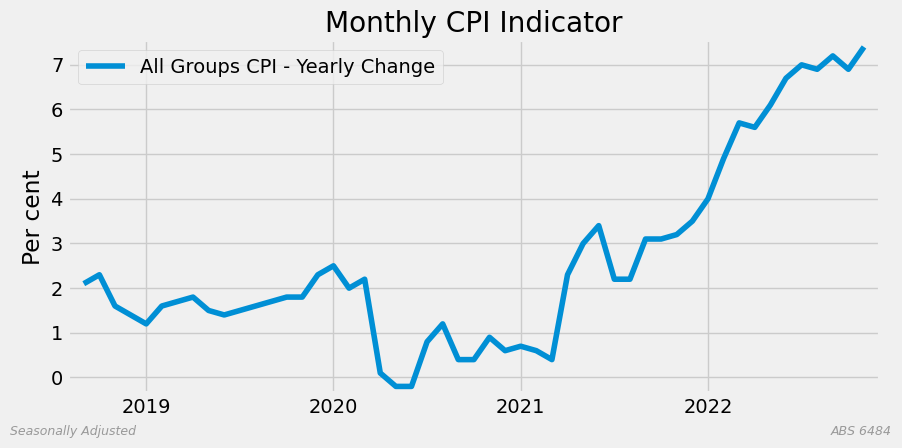

In [8]:
selectors = {
    # chart label
    'All Groups CPI - Yearly Change': 
    [
        ['Series Type', 'Seasonally Adjusted'],
        ['Data Item Description', 'All groups CPI'],
        ['Data Item Description', 'Previous Year'],
        ['Data Item Description', 'Percentage Change'],
    ],
}

plot = plot_constructor(selectors)

ax = plot.dropna().plot()
title = f'Monthly CPI Indicator'
tag = 'Annual Change'
series_type = 'Seasonally Adjusted'
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=series_type,
            show=True,
        )

69: Series Type, Seasonally Adjusted
6: Data Item Description, All groups CPI
3: Data Item Description, Previous Period
1: Data Item Description, Percentage Change
A128481589F 2


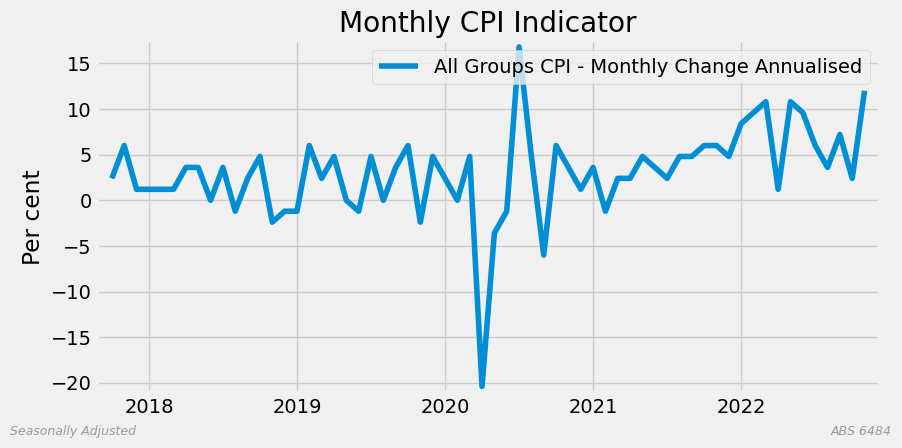

In [9]:
selectors = {
    # chart label
    'All Groups CPI - Monthly Change Annualised': 
    [
        ['Series Type', 'Seasonally Adjusted'],
        ['Data Item Description', 'All groups CPI'],
        ['Data Item Description', 'Previous Period'],
        ['Data Item Description', 'Percentage Change'],
    ],
}
plot_m = plot_constructor(selectors) * 12

ax = plot_m.dropna().plot()
title = f'Monthly CPI Indicator'
tag = 'Monthly Change Annualised'
series_type = 'Seasonally Adjusted'
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=series_type,
            show=True,
        )


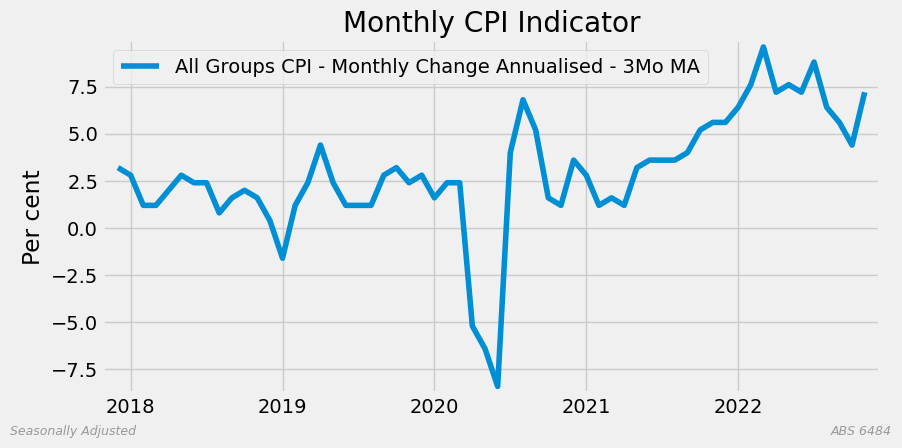

In [10]:
plot_ma = plot_m.rolling(3).mean()
c0 = {plot_ma.columns[0]: plot_ma.columns[0] + ' - 3Mo MA'}
plot_ma = plot_ma.rename(columns=c0)
ax = plot_ma.dropna().plot()
title = f'Monthly CPI Indicator'
tag = 'Monthly Change Annualised (3-Mo MA)'
series_type = 'Seasonally Adjusted'
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=series_type,
            show=True,
        )

69: Series Type, Seasonally Adjusted
6: Data Item Description, Trimmed Mean
3: Data Item Description, Previous Period
1: Data Item Description, Percentage Change
A128481595A 2


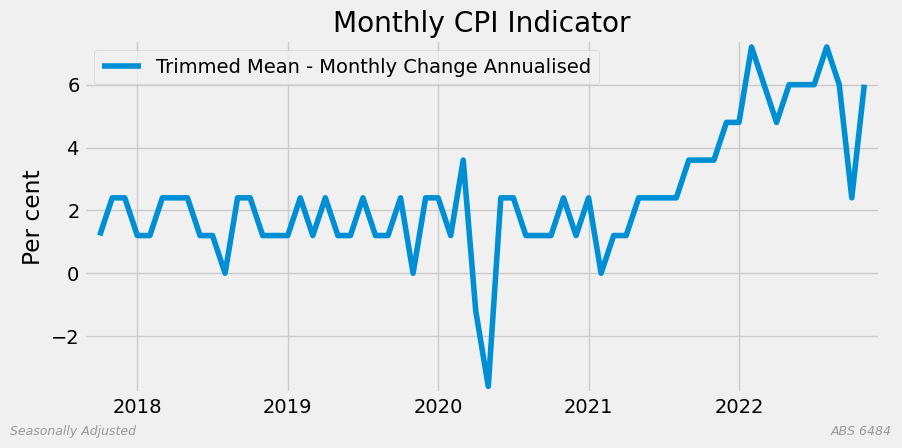

In [11]:
selectors = {
    # chart label
    'Trimmed Mean - Monthly Change Annualised': 
    [
        ['Series Type', 'Seasonally Adjusted'],
        ['Data Item Description', 'Trimmed Mean'],
        ['Data Item Description', 'Previous Period'],
        ['Data Item Description', 'Percentage Change'],
    ],
}
plot_tm = plot_constructor(selectors) * 12
ax = plot_tm.dropna().plot()
title = f'Monthly CPI Indicator'
tag = 'Trimmed Mean Monthly Change Annualised'
series_type = 'Seasonally Adjusted'
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=series_type,
            show=True,
        )